# Train and Test custom YOLOv11 on Amazon SageMaker Studio

In this notebook we will train and test a custom YOLOv11 object detection CV model within Amazon SageMaker Studio. 

**Steps:**

0. Initial configuration.
1. Download a labeled dataset.
3. Train the custom YOLOv11 model.
4. Make predictions against the created model. 


| ⚠️ WARNING: For this notebook to work, make sure to select the following settings in your jupyter environment: |
| -- |
Image: "PyTorch 1.10 Python 3.8 GPU Optimized"
Instance_type: "ml.g4dn.xlarge" (fast launch)

## 0. Initial Configuration

#### Download the YOLOv11 repository

In [ ]:
!git clone --quiet https://github.com/ultralytics/ultralytics

In [1]:
!pip install --no-input ultralytics

In [ ]:
!conda install --yes -c conda-forge opencv

In [2]:
import os
import boto3
import glob
s3_resource = boto3.resource('s3')

## 1. Download a labeled dataset with YOLOv11 expected format.

Before we train a custom YOLOv11 model, we need to have a labeled dataset. 
In the previous notebook "0 - Label your dataset with Amazon SageMaker GroundTruth" you will be able to label your own dataset and transform it into YOLOv11 expected format or use an example custom dataset. Once you have run through one of the two options you will have available the S3 dataset location and labels used.

In [5]:
#dataset_s3_uri = "s3://sagemaker-us-west-2-986221661979/yolov5-process-2025-01-03-11-38-21-706/output/train/training_data"
#labels = ['car number']

dataset_s3_uri = "s3://sagemaker-us-west-2-986221661979/yolov11-process-2025-01-08-04-47-28-958/output/train/training_data"
labels = ['Airplane', 'Car', 'Ferry', 'Helicopter', 'Motorbike']

#### Download the dataset

In [6]:
def split_s3_path(s3_path):
    path_parts=s3_path.replace("s3://","").split("/")
    bucket=path_parts.pop(0)
    key="/".join(path_parts)
    return bucket, key

In [7]:
bucket,dataset_name = split_s3_path(dataset_s3_uri)
bucket,dataset_name

('sagemaker-us-west-2-986221661979',
 'yolov11-process-2025-01-08-04-47-28-958/output/train/training_data')

In [8]:
def download_dataset(bucket_name, folder):
    bucket = s3_resource.Bucket(bucket_name) 
    for obj in bucket.objects.filter(Prefix = folder):
        if not os.path.exists(os.path.dirname(obj.key)):
            os.makedirs(os.path.dirname(obj.key))
        bucket.download_file(obj.key, obj.key)

In [9]:
download_dataset(bucket, dataset_name)

#### Lets explore our dataset

In [10]:
for filename in glob.iglob(dataset_name + '**/**', recursive=True):
     print(filename)

yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0007.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0016.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0019.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0059.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0061.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0068.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0123.jpeg
yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/images/train/image_0151.jpeg
yolov11-pr

# Now let's add these data sources to the data library in the yolov11 folder for our model to train

In [22]:
import os

current_path = os.getcwd()
print("현재 작업 디렉토리의 절대 경로:", current_path)

현재 작업 디렉토리의 절대 경로: /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio


In [25]:


with open("coco8.yaml", 'w') as target:
    target.write("path: {}\n".format(current_path+"/"+dataset_name))
    target.write("train: images/train\n")
    target.write("val: images/validation\n")
    target.write("names:\n")
    for i, label in enumerate(labels):
        target.write("  {}: {}\n".format(i, label))
        
with open('coco8.yaml') as file:
    lines = file.readlines()
    for line in lines:
        print(line)

path: /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio/yolov11-process-2025-01-08-04-47-28-958/output/train/training_data

train: images/train

val: images/validation

names:

  0: Airplane

  1: Car

  2: Ferry

  3: Helicopter

  4: Motorbike



# 3. Train the custom YOLOv11 model.

In [33]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolo11n.pt")

# Train the model
train_results = model.train(
    data="coco8.yaml",  # path to dataset YAML
    epochs=100,  # number of training epochs
    imgsz=640,  # training image size
    #device="cpu",  # device to run on, i.e. device=0 or device=0,1,2,3 or device=cpu
)

# Evaluate model performance on the validation set
metrics = model.val()


New https://pypi.org/project/ultralytics/8.3.58 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.57 🚀 Python-3.11.11 torch-2.3.1.post300 CPU (Intel Xeon Platinum 8259CL 2.50GHz)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=coco8.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train9, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames

train: Scanning /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio/yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/labels/train.cache... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<?, ?it/s]
val: Scanning /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio/yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/labels/validation.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]

Plotting labels to runs/detect/train9/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)


2025/01/08 05:52:17 WARNING mlflow.utils.autologging_utils: MLflow keras autologging is known to be compatible with 3.0.2 <= keras <= 3.5.0, but the installed version is 3.6.0. If you encounter errors during autologging, try upgrading / downgrading keras to a compatible version, or try upgrading MLflow.
2025/01/08 05:52:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2025/01/08 05:52:17 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2025/01/08 05:52:17 WARNING mlflow.utils.autologging_utils: MLflow statsmodels autologging is known to be compatible with 0.11.1 <= statsmodels <= 0.14.3, but the installed version is 0.14.4. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a compatible version, or try upgrading MLflow.
2025/01/08 05:52:17 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(a81ab9246df9429a9dd3fe0bab372ddd) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.712      3.626      1.869         23        640: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all          2          2       0.01          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.464      3.514      1.528         28        640: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all          2          2    0.00985          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.573      3.534      1.639         27        640: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]

                   all          2          2    0.00962          1      0.995      0.846



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.495      3.488      1.632         26        640: 100%|██████████| 1/1 [00:04<00:00,  4.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          2          2     0.0099          1      0.828      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.146      3.382      1.321         26        640: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all          2          2     0.0101          1      0.828      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.503      3.529      1.586         22        640: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          2          2     0.0102          1      0.828      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.149      3.436      1.333         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          2          2     0.0102          1      0.828      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G     0.9735      3.435      1.254         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          2          2     0.0104          1      0.828      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G     0.9588      3.369      1.267         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          2          2     0.0105          1      0.828      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G     0.8579      3.289       1.16         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all          2          2     0.0105          1      0.828      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G     0.7683      3.281      1.156         26        640: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2     0.0105          1      0.828      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G     0.8821      3.299      1.208         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all          2          2     0.0106          1      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G     0.9154      3.298      1.219         20        640: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          2          2     0.0106          1      0.995      0.796



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G     0.8193       3.24      1.091         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.98s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all          2          2     0.0108          1      0.828       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G     0.7965      3.259      1.189         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          2          2      0.011          1      0.995      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G     0.8043      3.183      1.166         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all          2          2     0.0108          1      0.995      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G     0.8408       3.22      1.312         22        640: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          2          2     0.0114          1      0.828      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G     0.6717      3.187      1.141         17        640: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all          2          2     0.0114          1      0.828      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G     0.9951      3.157      1.304         26        640: 100%|██████████| 1/1 [00:04<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          2          2     0.0108          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G     0.8147      3.267      1.281         18        640: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          2          2     0.0108          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G     0.9533      3.228      1.348         18        640: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          2          2     0.0116          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G     0.7955      2.977      1.135         27        640: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2     0.0116          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G     0.9069      3.085      1.146         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          2          2     0.0116          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G       0.89      3.128      1.261         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all          2          2     0.0116          1      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G     0.8109      3.092      1.196         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all          2          2      0.013          1      0.828      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      0.689      2.925      1.179         17        640: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2      0.013          1      0.828      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G     0.6295      2.825      1.106         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.26it/s]

                   all          2          2     0.0137          1      0.995      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G     0.7178      2.914      1.176         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2     0.0137          1      0.995      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G     0.9373      3.007      1.205         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all          2          2     0.0138          1      0.828      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G     0.7092      2.858      1.137         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.02it/s]

                   all          2          2     0.0138          1      0.828      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      0.613      2.662     0.9806         27        640: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all          2          2     0.0137          1      0.638      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G     0.8601      2.835      1.221         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all          2          2     0.0137          1      0.638      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G     0.7069      2.803      1.083         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all          2          2     0.0133          1      0.662      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G     0.8701      2.779      1.215         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all          2          2     0.0133          1      0.662      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G     0.7013      2.522      1.031         25        640: 100%|██████████| 1/1 [00:04<00:00,  4.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          2          2     0.0127          1      0.359      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G     0.8071      2.802      1.238         17        640: 100%|██████████| 1/1 [00:04<00:00,  4.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2     0.0127          1      0.359      0.213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G     0.5407      2.496      1.025         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all          2          2     0.0127          1      0.373      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      0.699      2.579      1.121         26        640: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          2          2     0.0127          1      0.373      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      0.729       2.56      1.118         20        640: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all          2          2     0.0114          1      0.347      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      0.623      2.483      1.084         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2     0.0114          1      0.347      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G     0.5144      2.239      1.026         27        640: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all          2          2     0.0108          1      0.331      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      0.684      2.417      1.041         26        640: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all          2          2     0.0108          1      0.331      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G     0.7438      2.289      1.093         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all          2          2     0.0103          1      0.331      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G     0.6979      2.407      1.094         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2     0.0103          1      0.331      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G     0.5802      2.238      1.057         23        640: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00976          1       0.29      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G     0.6152      2.249     0.9928         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all          2          2    0.00976          1       0.29      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      0.701      2.313      1.054         20        640: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all          2          2    0.00926          1      0.308       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G     0.5802      2.114      1.103         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all          2          2    0.00926          1      0.308       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G     0.7604      2.214      1.114         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00913          1      0.398      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G     0.6358      2.057      1.058         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2    0.00913          1      0.398      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G     0.4999      2.065     0.9661         25        640: 100%|██████████| 1/1 [00:04<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00866          1      0.448      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G     0.5943      1.985     0.9864         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00866          1      0.448      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G     0.6041      1.874      1.067         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2    0.00866          1      0.448      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G     0.6101      1.971     0.9419         26        640: 100%|██████████| 1/1 [00:03<00:00,  3.95s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2    0.00847          1      0.663      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G     0.6518      1.882      1.082         26        640: 100%|██████████| 1/1 [00:03<00:00,  3.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.29it/s]

                   all          2          2    0.00847          1      0.663      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G     0.6768      2.175      1.085         17        640: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.30it/s]

                   all          2          2    0.00847          1      0.663      0.173



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G     0.5571      1.884     0.9723         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          2          2    0.00826          1      0.663      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G     0.6348       1.73      0.904         22        640: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all          2          2    0.00826          1      0.663      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G     0.6077      1.891      1.081         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          2          2    0.00826          1      0.663      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G     0.5096      1.712       1.02         23        640: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00803          1      0.828      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G      0.608       1.63      1.113         23        640: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00803          1      0.828      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G     0.5506      1.842      1.076         20        640: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]

                   all          2          2    0.00803          1      0.828      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G     0.5634      1.689      1.043         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          2          2    0.00791          1      0.995      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G     0.5629       1.56     0.9218         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all          2          2    0.00791          1      0.995      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G     0.5185      1.649     0.9459         26        640: 100%|██████████| 1/1 [00:04<00:00,  4.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2    0.00791          1      0.995      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G     0.6354      1.808      1.057         27        640: 100%|██████████| 1/1 [00:03<00:00,  3.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          2          2    0.00778          1      0.995      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G     0.5682      1.705      1.036         20        640: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.25it/s]

                   all          2          2    0.00778          1      0.995      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G     0.5805      1.664     0.9625         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all          2          2    0.00778          1      0.995      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G     0.4983      1.604     0.9893         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all          2          2    0.00778          1      0.995      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G     0.4286      1.419     0.9682         17        640: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2    0.00778          1      0.995      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G     0.5765      1.565       1.01         22        640: 100%|██████████| 1/1 [00:04<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          2          2    0.00778          1      0.995      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G     0.5357      1.565      1.009         24        640: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          2          2    0.00775          1      0.995      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G     0.6037      1.476      1.015         24        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          2          2    0.00775          1      0.995      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G     0.5785      1.469      1.049         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all          2          2    0.00775          1      0.995      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G     0.6177      1.382     0.9972         21        640: 100%|██████████| 1/1 [00:04<00:00,  4.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all          2          2    0.00781          1      0.995      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G     0.5286      1.535      1.063         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all          2          2    0.00781          1      0.995      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G     0.5413      1.433      1.019         27        640: 100%|██████████| 1/1 [00:03<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all          2          2    0.00781          1      0.995      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G     0.4996      1.378     0.9998         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.16it/s]

                   all          2          2    0.00794          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G     0.4491      1.388     0.9631         14        640: 100%|██████████| 1/1 [00:03<00:00,  3.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          2          2    0.00794          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G     0.5924      1.426      1.053         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]

                   all          2          2    0.00794          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G     0.5129      1.425     0.9776         22        640: 100%|██████████| 1/1 [00:03<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all          2          2    0.00803          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G     0.6065      1.521     0.9897         25        640: 100%|██████████| 1/1 [00:03<00:00,  3.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all          2          2    0.00803          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G     0.5818      1.481      1.086         20        640: 100%|██████████| 1/1 [00:03<00:00,  3.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all          2          2    0.00803          1      0.995      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G     0.5845      1.479      0.936         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.05it/s]

                   all          2          2    0.00844          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G     0.5232      1.208     0.9389         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all          2          2    0.00844          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G     0.4434      1.387     0.9821         21        640: 100%|██████████| 1/1 [00:03<00:00,  3.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all          2          2    0.00844          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G     0.5106      1.298     0.9293         22        640: 100%|██████████| 1/1 [00:03<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.47it/s]

                   all          2          2    0.00844          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G     0.4673       1.25     0.8907         28        640: 100%|██████████| 1/1 [00:03<00:00,  3.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all          2          2     0.0084          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      0.436      1.213     0.8986         29        640: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.23it/s]

                   all          2          2     0.0084          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G     0.3878      1.319     0.9234         24        640: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.19it/s]

                   all          2          2     0.0084          1      0.995      0.673


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100         0G     0.3767      1.542     0.8624          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          2          2     0.0084          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      0.358      1.787     0.9692          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all          2          2    0.00855          1      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G     0.4153      1.699     0.9136          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.04it/s]

                   all          2          2    0.00855          1      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G     0.3794      1.625     0.9058          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.84s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all          2          2    0.00855          1      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G     0.3933      1.536     0.9485          8        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.10it/s]

                   all          2          2    0.00855          1      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G     0.4156      1.609      0.973          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all          2          2    0.00885          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      0.384      1.605     0.9171          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.89it/s]

                   all          2          2    0.00885          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G     0.4022      1.635     0.9376          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all          2          2    0.00885          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G     0.3126       1.54     0.8639          8        640: 100%|██████████| 1/1 [00:03<00:00,  3.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all          2          2    0.00885          1      0.995      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G     0.5764      1.901     0.9574          8        640: 100%|██████████| 1/1 [00:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all          2          2    0.00873          1      0.995      0.673



100 epochs completed in 0.136 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 5.5MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.57 🚀 Python-3.11.11 torch-2.3.1.post300 CPU (Intel Xeon Platinum 8259CL 2.50GHz)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


                   all          2          2    0.00962          1      0.995      0.846
             Motorbike          2          2    0.00962          1      0.995      0.846
Speed: 0.8ms preprocess, 125.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train9
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'
Ultralytics 8.3.57 🚀 Python-3.11.11 torch-2.3.1.post300 CPU (Intel Xeon Platinum 8259CL 2.50GHz)
YOLO11n summary (fused): 238 layers, 2,583,127 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio/yolov11-process-2025-01-08-04-47-28-958/output/train/training_data/labels/validation.cache... 2 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2/2 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


                   all          2          2    0.00962          1      0.995      0.846
             Motorbike          2          2    0.00962          1      0.995      0.846
Speed: 0.7ms preprocess, 105.7ms inference, 0.0ms loss, 4.3ms postprocess per image
Results saved to runs/detect/train92



image 1/1 /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio/validation_dataset/image_0271.jpg: 352x640 (no detections), 88.8ms
Speed: 1.9ms preprocess, 88.8ms inference, 0.4ms postprocess per image at shape (1, 3, 352, 640)


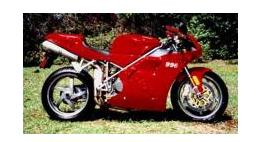

Ultralytics 8.3.57 🚀 Python-3.11.11 torch-2.3.1.post300 CPU (Intel Xeon Platinum 8259CL 2.50GHz)

PyTorch: starting from 'runs/detect/train9/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 9, 8400) (5.2 MB)

ONNX: starting export with onnx 1.17.0 opset 17...
ONNX: slimming with onnxslim 0.1.45...
ONNX: export success ✅ 2.0s, saved as 'runs/detect/train9/weights/best.onnx' (10.1 MB)

Export complete (2.3s)
Results saved to /home/sagemaker-user/amazon-sagemaker-train-and-deploy-yolov11/notebooks/1 - Train and test on Amazon SageMaker Studio/runs/detect/train9/weights
Predict:         yolo predict task=detect model=runs/detect/train9/weights/best.onnx imgsz=640  
Validate:        yolo val task=detect model=runs/detect/train9/weights/best.onnx imgsz=640 data=coco8.yaml  
Visualize:       https://netron.app
export model path: runs/detect/train9/weights/best.onnx


In [34]:

# Perform object detection on an image
results = model("./validation_dataset/image_0271.jpg")
results[0].show()

# Export the model to ONNX format
path = model.export(format="onnx")  # return path to exported model
print("export model path:", path)

## 4. Make inferences with the created model.

In [ ]:
#!python yolov5/detect.py --weights yolov5/runs/train/exp/weights/best.pt --img 640 --conf 0.5 --source ""

| ⚠️ WARNING: Remember to shutdown the instance once finalized with this notebook to prevent unnecesary charges. Head to running Terminals and Kernels tab and shutdown the running instance. |
| -- |